# Using mlflow to log models

This notebook shows how to use Mlflow for automatically logging model metrics and parameters with `tensorflow.keras`. This is a very good way to keep track of the various models one may use for solving problems.

- [mlflow docs](https://mlflow.org/docs/latest/quickstart.html)
- [python documentation](https://mlflow.org/docs/latest/python_api/index.html)

In [15]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt


import mlflow.tensorflow

mlflow.tensorflow.autolog()  # call to automatically log metrics and parameters

%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


# Load and prepare data

For this example I'm using [fashion mnist](https://www.tensorflow.org/datasets/catalog/fashion_mnist), which is like the 'hello world' of computer vision. We load the train and test data, create a validation dataset of 10,000 images and then standardize the data.

In [6]:
(X_train_full, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

validation_size = 10000
X_train, y_train = X_train_full[:-validation_size], y_train[:-validation_size]
X_valid, y_valid = X_train_full[-validation_size:], y_train[-validation_size:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7

# Standardize
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

# Add a single channel to the last dimension to signify we're working with 
# greyscale image
X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

print(f"X_train shape: {X_train.shape}")
print(f"X_valid shape: {X_valid.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (50000, 28, 28, 1)
X_valid shape: (10000, 28, 28, 1)
X_test shape: (10000, 28, 28, 1)


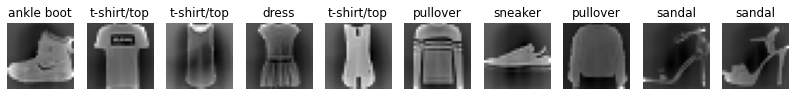

In [12]:
labels = [
    "t-shirt/top",
    "trouser",
    "pullover",
    "dress",
    "coat",
    "sandal",
    "shirt",
    "sneaker",
    "bag",
    "ankle boot",
]
fig, axes = plt.subplots(1, 10, figsize=(14, 6))

for idx, ax in enumerate(axes):
    ax.imshow(X_train[idx], "gray")
    ax.set_title(labels[y_train[idx]])
    ax.axis("off")
plt.show()

Define a  model for training

In [14]:
def build_model(activation="relu", padding="SAME"):
    model = keras.models.Sequential(
        [
            keras.layers.Conv2D(
                64, 7, input_shape=[28, 28, 1], activation=activation, padding=padding
            ),
            keras.layers.MaxPooling2D(2),
            keras.layers.Conv2D(64, 3, activation=activation, padding=padding),
            keras.layers.MaxPooling2D(2),
            keras.layers.Conv2D(128, 3, activation=activation, padding=padding),
            keras.layers.MaxPooling2D(2),
            keras.layers.Flatten(),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(64, activation=activation),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(10, activation="softmax"),
        ]
    )
    return model

Now we use the mlflow `start_run` context so that mlflow knows to start capturing. We can also add extra metrics and parameters by using `mlflow.log_param` or `mlflow.log_metric` and passing a key value pair with the name and value of the object we want to track.

In [16]:
with mlflow.start_run():
    model = build_model()
    epochs = 5
    batch_size = 32
    learning_rate = 1e-3

    model.compile(
        optimizer=keras.optimizers.Nadam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    model.fit(
        X_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_valid, y_valid),
    )

    y_test_preds = model.evaluate(X_test, y_test)
    # log a custom metric
    mlflow.log_metric("test_accuracy", y_test_preds)

    # log a custom parameter
    mlflow.log_param("model_name", "small_keras_fashion_mnist")

Epoch 1/10
1563/1563 [==============================] - 37s 19ms/step - loss: 0.7110 - accuracy: 0.7579 - val_loss: 12.9951 - val_accuracy: 0.1050
Epoch 2/10
1563/1563 [==============================] - 26s 17ms/step - loss: 0.4148 - accuracy: 0.8622 - val_loss: 17.0034 - val_accuracy: 0.1046
Epoch 3/10
1563/1563 [==============================] - 27s 17ms/step - loss: 0.3591 - accuracy: 0.8802 - val_loss: 16.8458 - val_accuracy: 0.1032
Epoch 4/10
1563/1563 [==============================] - 26s 16ms/step - loss: 0.3300 - accuracy: 0.8890 - val_loss: 27.9745 - val_accuracy: 0.1041
Epoch 5/10
1563/1563 [==============================] - 27s 17ms/step - loss: 0.3020 - accuracy: 0.8955 - val_loss: 29.2509 - val_accuracy: 0.1051
Epoch 6/10
 186/1563 [==>...........................] - ETA: 23s - loss: 0.2760 - accuracy: 0.9046

KeyboardInterrupt: 

By default, MLFlow will save results to a folder called `mlruns` on the current directory you're in. To view results of the run, navigate to this directory via terminal and use the command `mlflow ui`. Then on your browser open `localhost:5000` and you'll be greeted with the mlflow interface.